---
title: "FRAMINGHAM HEART STUDY"
author: "Asabere Kwabena Asante"
df-print: kable
code-overflow: wrap
execute: 
  echo: true
  warning: false
  message: false
format: html
editor: visual
editor_options: 
  chunk_output_type: console
---

In [67]:
## load required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [68]:
# import the Framingham study dataset
framingham_data = pd.read_csv(r"C:\Users\KAsab\Desktop\PORTFOLIO PROJECTS\framingham_heart_study.csv")

In [69]:
framingham_data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


### **EDA**

In [70]:
print(framingham_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB
None


In [71]:
## numerical summaries of variables
print(framingham_data.describe())

              male          age    education  currentSmoker   cigsPerDay  \
count  4240.000000  4240.000000  4135.000000    4240.000000  4211.000000   
mean      0.429245    49.580189     1.979444       0.494104     9.005937   
std       0.495027     8.572942     1.019791       0.500024    11.922462   
min       0.000000    32.000000     1.000000       0.000000     0.000000   
25%       0.000000    42.000000     1.000000       0.000000     0.000000   
50%       0.000000    49.000000     2.000000       0.000000     0.000000   
75%       1.000000    56.000000     3.000000       1.000000    20.000000   
max       1.000000    70.000000     4.000000       1.000000    70.000000   

            BPMeds  prevalentStroke  prevalentHyp     diabetes      totChol  \
count  4187.000000      4240.000000   4240.000000  4240.000000  4190.000000   
mean      0.029615         0.005896      0.310613     0.025708   236.699523   
std       0.169544         0.076569      0.462799     0.158280    44.591284   

In [72]:
## check for missing values
print(framingham_data.isnull().sum())

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64


In [73]:
## group variables 
categorical_features = ['male','currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes'] # coded as dummy variables
numeric_features = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']


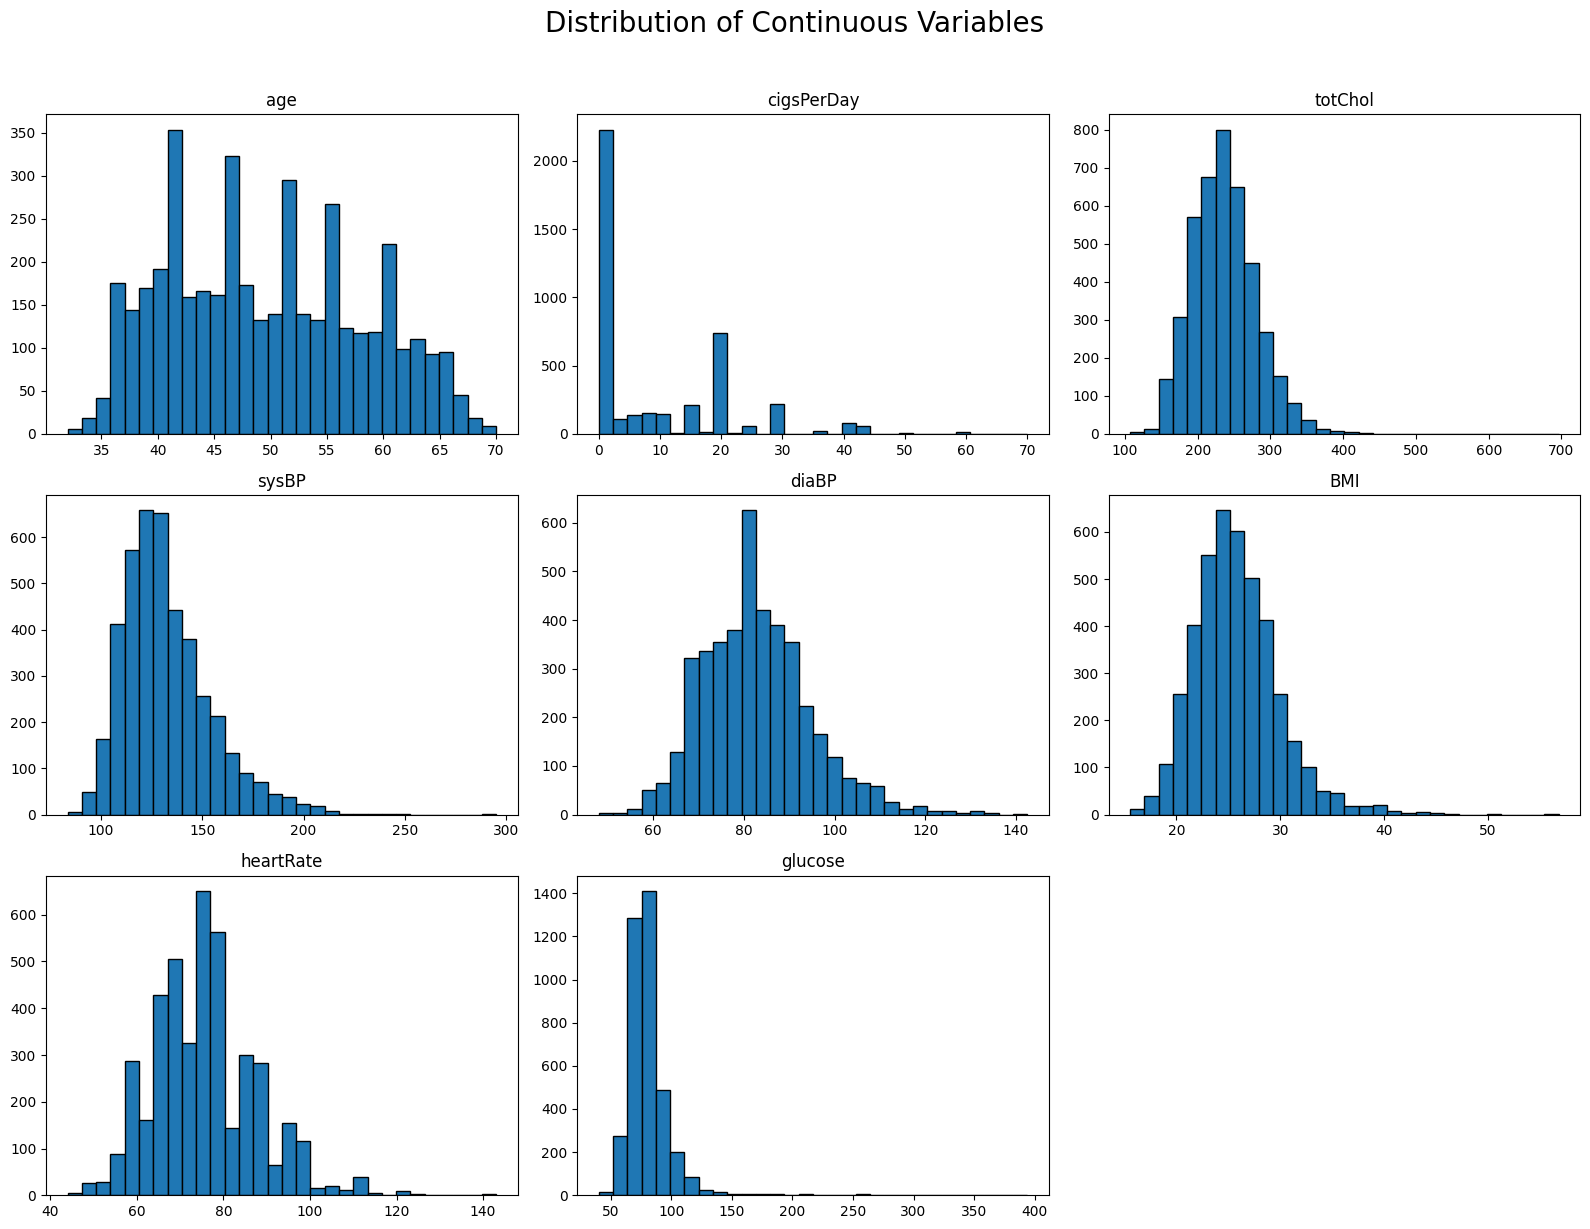

In [74]:

framingham_data[numeric_features].hist(
    figsize=(16,12),
    edgecolor = "black",
    bins=30,
    grid=False
)
plt.grid(True, linestyle='--', alpha=0.6)
plt.suptitle('Distribution of Continuous Variables', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()




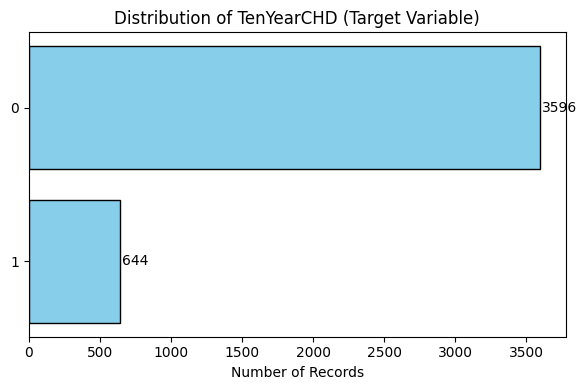

In [75]:
# Sort value counts
chd_counts = framingham_data['TenYearCHD'].value_counts().sort_values()

# Plot
plt.figure(figsize=(6, 4))
bars = plt.barh(chd_counts.index.astype(str), chd_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("Number of Records")
plt.title("Distribution of TenYearCHD (Target Variable)")
# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 10, bar.get_y() + bar.get_height() / 2,
             f'{width}', va='center', fontsize=10)

plt.tight_layout()
plt.show()


The distribution of the target variable shows class imbalance with the negative class considerably higher in proportion.

### **Preprocessing**

In [76]:
## features
X = framingham_data.iloc[:,:-1]
y = framingham_data.iloc[:,-1]

In [77]:
## split into training and test set 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [78]:
## create preproceesing pipelines
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Numeric pipeline
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline,make_column_selector(dtype_include=np.number)),
    ('cat', categorical_pipeline,make_column_selector(dtype_include=object))
])

# Fit and transform training data, transform test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)




### **Model Training**

Due to class imbalance of the target variable, `SMOTE`(Synthetic Minority Oversampling Technique) will be incorporated into the model training pipeline

In [79]:
# Define models with SMOTE in pipeline
models = {
    "Logistic Regression": (
        ImbPipeline([
            ('preprocess', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('clf', LogisticRegression(max_iter=1000))
        ]),
        {'clf__C': [0.01, 0.1, 1, 10]}
    ),
    "Random Forest": (
        ImbPipeline([
            ('preprocess', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('clf', RandomForestClassifier(random_state=42))
        ]),
        {'clf__n_estimators': [100, 200], 'clf__max_depth': [5, 10, None]}
    ),
    "XGBoost": (
        ImbPipeline([
            ('preprocess', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('clf', XGBClassifier(eval_metric='logloss', use_label_encoder=False))
        ]),
        {'clf__n_estimators': [100, 200], 'clf__max_depth': [3, 5, 7]}
    )
}



Logistic Regression Best Params: {'clf__C': 0.01}
              precision    recall  f1-score   support

           0       0.91      0.68      0.78       719
           1       0.25      0.60      0.36       129

    accuracy                           0.67       848
   macro avg       0.58      0.64      0.57       848
weighted avg       0.81      0.67      0.71       848

Confusion Matrix:
 [[490 229]
 [ 51  78]]
ROC AUC: 0.6972

Random Forest Best Params: {'clf__max_depth': 5, 'clf__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       719
           1       0.26      0.51      0.35       129

    accuracy                           0.71       848
   macro avg       0.58      0.63      0.58       848
weighted avg       0.80      0.71      0.74       848

Confusion Matrix:
 [[532 187]
 [ 63  66]]
ROC AUC: 0.6760

XGBoost Best Params: {'clf__max_depth': 3, 'clf__n_estimators': 100}
              precision    recall

c:\Users\KAsab\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:29:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


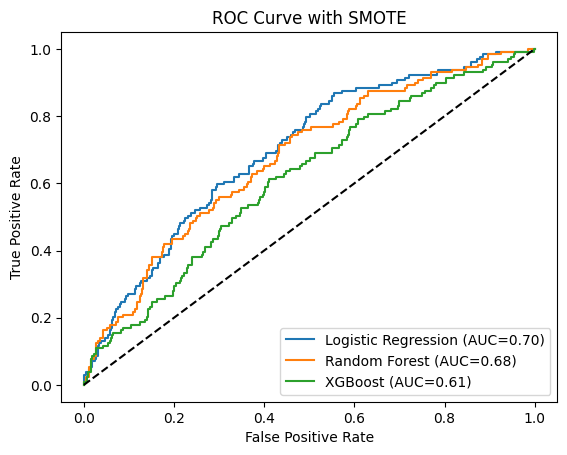

In [89]:
best_model = None
best_auc = 0

for name, (pipeline, param_grid) in models.items():
    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)

    print(f"\n{name} Best Params: {grid.best_params_}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"ROC AUC: {auc:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

    if auc > best_auc:
        best_auc = auc
        best_model = grid.best_estimator_

# ROC Curve
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with SMOTE")
plt.legend()
plt.show()


In [91]:
best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000219C21A95B0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000219C9B78B60>)])),
                ('smote', SMOTE(random_state=42)),
                ('clf', LogisticRegression(C=0.01, max_iter=1000))])


Logistic Regression Best Params: {'clf__C': 0.01}
              precision    recall  f1-score   support

           0       0.91      0.68      0.78       719
           1       0.25      0.60      0.36       129

    accuracy                           0.67       848
   macro avg       0.58      0.64      0.57       848
weighted avg       0.81      0.67      0.71       848

Confusion Matrix:
 [[490 229]
 [ 51  78]]
ROC AUC: 0.6138

Random Forest Best Params: {'clf__max_depth': 5, 'clf__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       719
           1       0.26      0.51      0.35       129

    accuracy                           0.71       848
   macro avg       0.58      0.63      0.58       848
weighted avg       0.80      0.71      0.74       848

Confusion Matrix:
 [[532 187]
 [ 63  66]]
ROC AUC: 0.6138

XGBoost Best Params: {'clf__max_depth': 3, 'clf__n_estimators': 100}
              precision    recall

c:\Users\KAsab\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:29:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


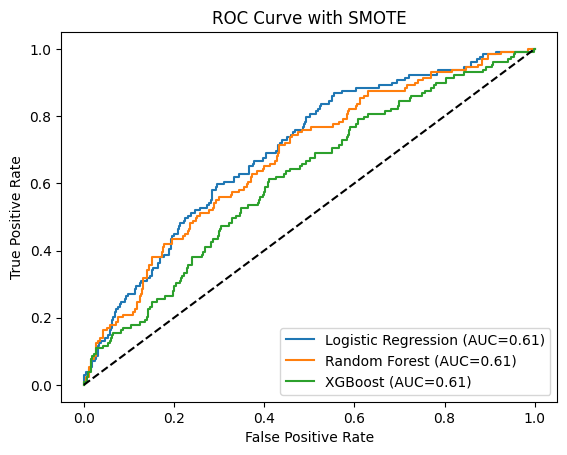

In [90]:
fitted_models = {}

for name, (pipeline, param_grid) in models.items():
    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    fitted_models[name] = grid.best_estimator_  # Save fitted model
    
    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1]

    print(f"\n{name} Best Params: {grid.best_params_}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"ROC AUC: {auc:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

    if auc > best_auc:
        best_auc = auc
        best_model = grid.best_estimator_

# ROC Curve
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with SMOTE")
plt.legend()
plt.show()



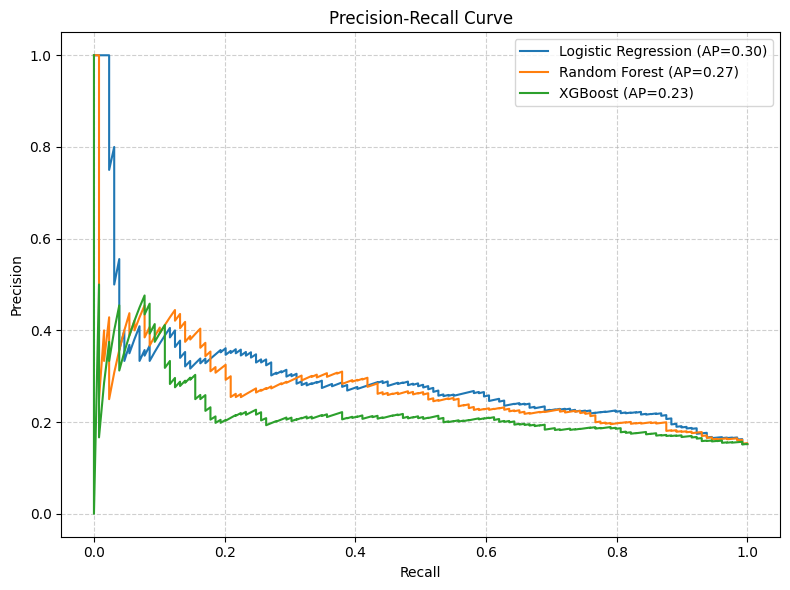

In [82]:
### Precision-Recall Curve

plt.figure(figsize=(8,6))
for name, model in fitted_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    plot_precision_recall_curve(y_test, y_proba, name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
